In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

## Read Data.

In [2]:
df = pd.read_csv("../input/flickr8k/captions.txt", sep=',')
print(len(df))
df.head(5)

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


## Preprocessing -> Remove Single Character and non alpha Words. Add <Start>, <end> and <pad> tokens. <pad> token is appended such that length in max_seq_len (maximum length across all captions which is 33 in our case)  

In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['clean_captions'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['clean_captions']  = df['clean_captions'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_length'] = df['clean_captions'].apply(lambda x : len(x))
max_seq_len = df['seq_length'].max()
print(max_seq_len)

33


In [6]:
df.drop(['seq_length'], axis = 1, inplace = True)
df['clean_captions'] = df['clean_captions'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [7]:
df.head(2)

,image,caption,clean_captions
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


## Create Vocab and mapping of token to ID

In [8]:
words_list = df['clean_captions'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
words_dict = Counter(words_list)
words_dict =  sorted(words_dict, key=words_dict.get, reverse=True)

In [9]:
print(len(words_dict))
print(words_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


### Vocab size is 8360

In [10]:
vocab_size = len(words_dict)
print(vocab_size)

8360


In [11]:
index_to_word = {index: word for index, word in enumerate(words_dict)}
word_to_index = {word: index for index, word in enumerate(words_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


### Covert sequence of tokens to IDs

In [12]:
df['text_seq']  = df['clean_captions'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [13]:
df.head(2)

,image,caption,clean_captions,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Split In Train and validation data. Same Image should not be present in both training and validation data 

In [14]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [15]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


## Extract features from Images Using Resnet

In [16]:
train_samples = len(train)
print(train_samples)

36409


In [17]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class extractImageFeatureDataSet():
    def __init__(self, data, size):
        self.data = data 
        self.scaler = transforms.Resize([size,size])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '../input/flickr8k/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [20]:
train_ImageDataset_ResNet = extractImageFeatureDataSet(unq_train_imgs , 224)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

valid_ImageDataset_ResNet = extractImageFeatureDataSet(unq_valid_imgs , 224)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [21]:
train_ImageDataset_Inception = extractImageFeatureDataSet(unq_train_imgs, 340)
train_ImageDataloader_Inception = DataLoader(train_ImageDataset_Inception, batch_size = 1, shuffle=False)

valid_ImageDataset_Inception = extractImageFeatureDataSet(unq_valid_imgs, 340)
valid_ImageDataloader_Inception = DataLoader(valid_ImageDataset_Inception, batch_size = 1, shuffle=False)

In [22]:
for ima,image in tqdm(train_ImageDataloader_ResNet):
    print(f'Image size for Resnet Features: {image.shape}')
    break

  0%|          | 0/7282 [00:00<?, ?it/s]

Image size for Resnet Features: torch.Size([1, 3, 224, 224])


In [23]:
for ima,image in tqdm(train_ImageDataloader_Inception):
    print(f'Image size for Inception Features: {image.shape}')
    break

  0%|          | 0/7282 [00:00<?, ?it/s]

Image size for Inception Features: torch.Size([1, 3, 340, 340])


In [24]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [25]:
inception = torchvision.models.Inception3(init_weights=True).to(device)
inception.eval()
list(inception._modules)

['Conv2d_1a_3x3',
 'Conv2d_2a_3x3',
 'Conv2d_2b_3x3',
 'maxpool1',
 'Conv2d_3b_1x1',
 'Conv2d_4a_3x3',
 'maxpool2',
 'Mixed_5b',
 'Mixed_5c',
 'Mixed_5d',
 'Mixed_6a',
 'Mixed_6b',
 'Mixed_6c',
 'Mixed_6d',
 'Mixed_6e',
 'AuxLogits',
 'Mixed_7a',
 'Mixed_7b',
 'Mixed_7c',
 'avgpool',
 'dropout',
 'fc']

In [26]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

inceptionLayer7 = inception._modules.get('Mixed_7c').to(device)

In [27]:
def get_resnet_vector(t_img):
    
    t_img = Variable(t_img)
#     print(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    
    h.remove()
    return my_embedding

In [28]:
def get_inception_vector(t_img):
    
    t_img = Variable(t_img)
    
    #embedding size is the last layer size
    my_embedding = torch.zeros(1, 2048, 9, 9)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = inceptionLayer7.register_forward_hook(copy_data)
    inception(t_img)
    
    h.remove()
    return my_embedding

In [29]:
def writeResnetPickle(loader,name):
    picklDict = {}
    for image_name,img in tqdm(loader):
        img = img.to(device)
        embdg = get_resnet_vector(img)
        
        picklDict[image_name[0]] =  embdg
    
    a_file = open(f'./{name}.pkl', "wb")
    pickle.dump(picklDict, a_file)
    a_file.close()
    
    return "Done"

In [30]:
def writeInceptionPickle(loader,name):
    picklDict = {}
    for image_name,img in tqdm(loader):
        img = img.to(device)
        embdg = get_inception_vector(img)
        
        picklDict[image_name[0]] =  embdg
    
    a_file = open(f'./{name}.pkl', "wb")
    pickle.dump(picklDict, a_file)
    a_file.close()
    
    return "Done"

In [31]:
writeResnetPickle(train_ImageDataloader_ResNet,'resnetTrainEncoder')
writeResnetPickle(valid_ImageDataloader_ResNet,'resnetValidEncoder')

  0%|          | 0/7282 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

'Done'

In [32]:
writeInceptionPickle(train_ImageDataloader_Inception,'inceptionTrainEncoder')
writeInceptionPickle(valid_ImageDataloader_Inception,'inceptionValidEncoder')

  0%|          | 0/7282 [00:00<?, ?it/s]

  0%|          | 0/810 [00:00<?, ?it/s]

'Done'

## Create DataLoader which will be used to load data into Transformer Model.
## FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.

In [33]:
class FlickerDataSet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [34]:
def getEncodedLoader(data,pickleFile,train):
    dataset = FlickerDataSet(data,pickleFile)
    if train:
        loader = DataLoader(dataset, batch_size = 32, shuffle = True)
    else:
        loader = DataLoader(dataset, batch_size = 32, shuffle = False)
    
    return loader

In [35]:
train_resnet_loader = getEncodedLoader(train,'resnetTrainEncoder.pkl',True)
valid_resnet_loader = getEncodedLoader(valid, 'resnetValidEncoder.pkl',False)

In [36]:
train_inception_loader = getEncodedLoader(train,'inceptionTrainEncoder.pkl',True)
valid_inception_loader = getEncodedLoader(valid,'inceptionValidEncoder.pkl',False)

## Create Transformer Decoder Model. This Model will take caption sequence and the extracted resnet image features as input and ouput 1 timestep shifted (left) caption sequence. 
## In the Transformer decoder, lookAhead and padding mask has also been applied

### Position Embedding

In [37]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [38]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        
#         print(decoder_inp)
        
#         print(self.embedding_size)
        
        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
#         print(f'First one: {decoder_inp_embed}')
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
#         print(f'mask: {decoder_input_mask}')
#         print(f'second one: {decoder_inp_embed}')

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


##  Train the Model

### The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [39]:
EPOCH = 25

In [40]:
# embedding size 2048 for inception 9 X 9 output layer

In [41]:
ictModel = ImageCaptionModel(n_head=16, n_decoder_layer=5, vocab_size=vocab_size, embedding_size=2048).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

In [42]:
train_losses = []
valid_losses = []
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_inception_loader:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_inception_loader:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
    
    
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
    
    train_losses.append(total_epoch_train_loss.item())
    valid_losses.append(total_epoch_valid_loss.item())
    
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel.pt')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  6.0992112159729 Eval Loss ->  5.5920586585998535
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  5.749101638793945 Eval Loss ->  5.578451156616211
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  5.720700740814209 Eval Loss ->  5.573095321655273
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  5.703803539276123 Eval Loss ->  5.580995082855225
Epoch ->  4  Training Loss ->  5.6910271644592285 Eval Loss ->  5.5834221839904785
Epoch ->  5  Training Loss ->  5.683437347412109 Eval Loss ->  5.583168029785156
Epoch     6: reducing learning rate of group 0 to 8.0000e-06.
Epoch ->  6  Training Loss ->  5.672372817993164 Eval Loss ->  5.587848663330078
Epoch ->  7  Training Loss ->  5.663800239562988 Eval Loss ->  5.588690280914307
Epoch ->  8  Training Loss ->  5.6576385498046875 Eval Loss ->  5.590116024017334
Epoch     9: reducing learning rate of group 0 to 6.4000e-06.
Epoch ->  9  Training Loss ->  5.654189586639404 Eval Loss ->  5.59

In [43]:
torch.save(ictModel,'FinalModel.pt')

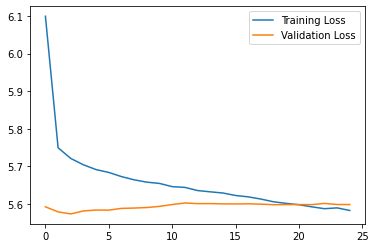

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(valid_losses, label = 'Validation Loss')

plt.legend()
plt.show()

plt.savefig('Loss.png')

## Lets Generate Captions !!!

In [45]:
model = torch.load('BestModel.pt')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [46]:
valid_img_embed = pd.read_pickle('inceptionValidEncoder.pkl')

### Here in the below function,we are generating caption in beam search. K defines the topK token to look at each time step

In [47]:
def generate_caption(K, img_nm): 
    img_loc = '../input/flickr8k/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted caption : 
<pad> .


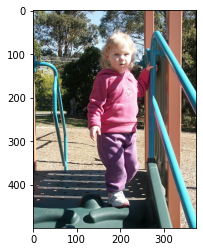

In [48]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])